# Single Shot Multibox Detector (SSD) Model for Object Detection


This notebook serves as an additional exploration in our project, where we tested the SSD model directly on our drone data as well as on a labeled dataset from Roboflow. Without any training or fine-tuning, the SSD model showed poor results, failing to detect objects accurately, especially on our unlabeled drone footage. Given these findings, we will proceed with YOLO, which has shown better performance with our data and has a stronger ability to generalize in this context.

In [ ]:
!pip install roboflow
!pip install opencv-python
!pip install torchvision
!pip install tqdm

from roboflow import Roboflow
import torch
import torchvision.transforms as T
from torchvision.models.detection import ssd300_vgg16
from torchvision.datasets import CocoDetection
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

video_path = '/content/drive/My Drive/parking_ML.mp4'

Mounted at /content/drive


# Visualizing Our Drone Data


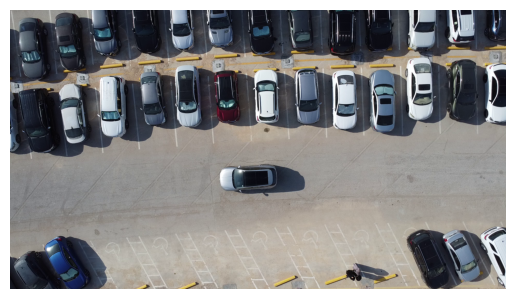

In [ ]:

# Open the video from Google Drive
cap = cv2.VideoCapture(video_path)

# Check if the video is loaded correctly
if not cap.isOpened():
    print("Error opening video file")
else:
    # Example of reading a single frame
    ret, frame = cap.read()
    if ret:
        # Convert BGR (OpenCV format) to RGB (Matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using Matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Hide the axes
        plt.show()

cap.release()

# Load pre-trained SSD model

In [ ]:

# Load pre-trained SSD model
model = ssd300_vgg16(pretrained=True)
model.eval()
model = model.to('cuda')

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:04<00:00, 29.3MB/s]


# These functions collaboratively handle the detection process:

 resizing frames to fit model requirements, performing detection, and then drawing bounding boxes on the detected objects for visual feedback.

In [ ]:

# Function to preprocess frame
def preprocess_frame(frame):
    return cv2.resize(frame, (300, 300))

# Function to detect objects
def detect_objects(frame, model):
    # Convert frame (NumPy array) to a tensor and move to GPU
    frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float().unsqueeze(0).to('cuda')
    # Apply SSD model
    with torch.no_grad():
        predictions = model(frame_tensor)

    return predictions

# Function to visualize predictions
def visualize_predictions(frame, predictions, threshold=0.5):
    # Extract bounding boxes and labels
    boxes = predictions[0]['boxes'].detach().cpu().numpy()  # Move to CPU for visualization
    scores = predictions[0]['scores'].detach().cpu().numpy()
    for i in range(len(scores)):
        if scores[i] > threshold:
            box = boxes[i].astype(int)
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

    return frame


# Frame-by-Frame Object Detection

This block sequentially processes each frame, applies object detection, visualizes the results, and saves the output, while tracking progress and time per frame.

In [ ]:

# Video processing loop
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
output_video = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (300, 300))

with tqdm(total=frame_count) as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        if frame_preprocessed is None:
            pbar.update(1)
            continue

        # Detect objects
        predictions = detect_objects(frame_preprocessed, model)

        # Visualize predictions
        frame_with_boxes = visualize_predictions(frame_preprocessed, predictions)

        # Write the processed frame to the output video
        output_video.write(frame_with_boxes)

        # Update progress bar
        pbar.update(1)

# Release resources
cap.release()
output_video.release()
cv2.destroyAllWindows()

100%|██████████| 21237/21237 [14:13<00:00, 24.89it/s]




---



# Testing

Now, we will evaluate the model's performance using an external dataset and analyze its precision and recall.

[sorce of the labeled data](https://universe.roboflow.com/models/object-detection)

# Dataset Download and Path Configuration

In [ ]:
# Initialize Roboflow with API key to access project data
rf = Roboflow(api_key="deuFW7xh3HQix2yhGtaH")
# Specify the workspace and project within Roboflow
project = rf.workspace("project-xv6fp").project("cartopview")
version = project.version(7)
# Download the dataset in COCO format and save it to the local environment
dataset = version.download("coco")

# Paths to the images and annotations
image_folder = "CarTopView-7/test"
annotation_file = "CarTopView-7/test/_annotations.coco.json"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CarTopView-7 in coco:: 100%|██████████| 2579/2579 [00:01<00:00, 1393.66it/s]


# This code cell loads COCO-style annotations from a JSON file and defines functions to visualize bounding boxes on images

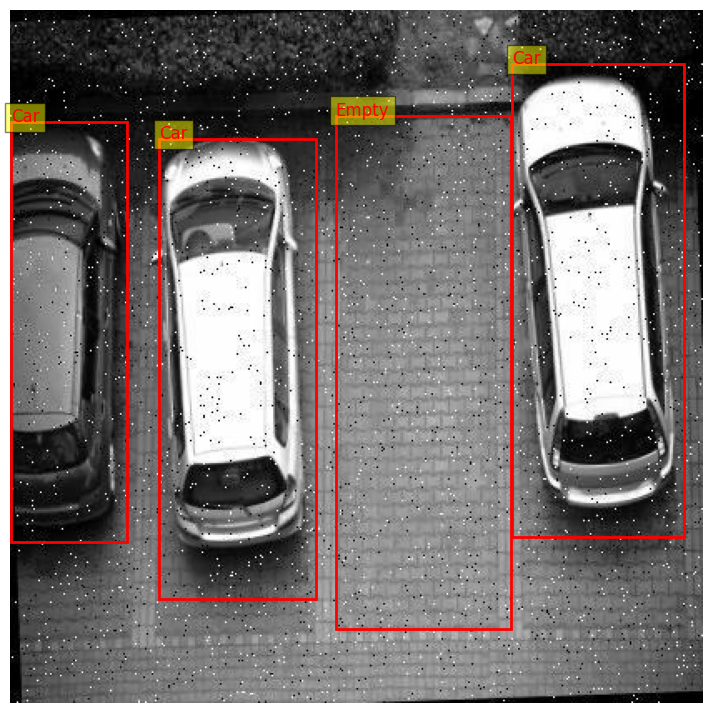

In [ ]:

# Load COCO annotations
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Helper function to get annotations for a specific image
def get_annotations(image_id):
    return [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

# Visualize function to display image with bounding boxes
def visualize_image_with_annotations(image_info):
    # Load image
    image_path = os.path.join(image_folder, image_info['file_name'])
    image = Image.open(image_path).convert("RGB")

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Get annotations for the image
    annotations = get_annotations(image_info['id'])

    # Plot each bounding box
    for ann in annotations:
        bbox = ann['bbox']  # Bounding box coordinates (x, y, width, height)
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Optional: add the category name if needed
        category_id = ann['category_id']
        category_name = next(cat['name'] for cat in coco_data['categories'] if cat['id'] == category_id)
        plt.text(x, y, category_name, color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Select and visualize the first image in the dataset
first_image_info = coco_data['images'][0]
visualize_image_with_annotations(first_image_info)


In [ ]:
# Load test dataset in COCO format
transform = T.Compose([T.ToTensor()])
test_dataset = CocoDetection(root=image_folder, annFile=annotation_file, transform=transform)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:

# Run model on test dataset and collect predictions
all_coco_results = []

for idx, (image, _) in enumerate(test_dataset):
    image_id = test_dataset.ids[idx]
    image = image.unsqueeze(0).to('cuda') # Add batch dimension and move to GPU

    # Run inference
    with torch.no_grad():
        predictions = model(image)

    # Convert predictions to COCO format
    coco_results = convert_to_coco_format(predictions, image_id)
    all_coco_results.extend(coco_results)

# Save predictions to a JSON file
with open("ssd_predictions.json", "w") as f:
    json.dump(all_coco_results, f)

# Load ground truth and predictions for COCO evaluation
coco_gt = COCO(annotation_file)
coco_dt = coco_gt.loadRes("ssd_predictions.json")

# Evaluate using COCO API
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.77s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Overall, these metrics suggest:


*   The model has low precision (struggles to align predicted boxes accurately with ground truths) and low recall (misses many objects).
*   It performs slightly better at lower IoU thresholds (AP50) but still misses many objects, reflected in low AR.
*   Larger objects are detected slightly better than smaller ones, but performance remains low across all sizes.




In [ ]:

# Load ground truth and predictions
coco_gt = COCO(annotation_file)  # Ground truth annotations path
coco_dt = coco_gt.loadRes("ssd_predictions.json")  # Predictions path

# Initialize COCOeval
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
iou_threshold = 0.5
coco_eval.params.iouThrs = np.array([iou_threshold])  # Set single IoU threshold for simplicity
coco_eval.params.maxDets = [100]  # Limiting to the top 100 detections
coco_eval.evaluate()
coco_eval.accumulate()

# Extract TP, FP, FN based on COCOeval's summary
# 'precision' array: [iou, recall, category, area range, max detections]
precision = coco_eval.eval['precision']
recall = coco_eval.eval['recall']

# Precision at the specified IoU threshold
precision_at_iou = precision[0, :, :, 0, -1]  # AP for all classes and max detections
recall_at_iou = recall[0, :, :, 0]  # Recall at the same IoU threshold

# Calculate average precision and recall for the dataset at IoU threshold
average_precision = np.mean(precision_at_iou[precision_at_iou > -1])
average_recall = np.mean(recall_at_iou[recall_at_iou > -1])

# Approximate Accuracy
approximate_accuracy = (2 * average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) > 0 else 0

print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Approximate (F1 Score): {approximate_accuracy:.4f}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.01s).
Average Precision: 0.0314
Average Recall: 0.1352
Approximate Accuracy (F1 Score): 0.0510


In object detection or imbalanced datasets (where one class vastly outnumbers the other), accuracy can be misleading because it doesn’t account for the balance between precision and recall.

In [ ]:

# Helper function to visualize bounding boxes on an image
def visualize_boxes(ax, image, boxes, scores=None, labels=None, title=""):
    ax.imshow(image)
    for i, box in enumerate(boxes):
        x_min, y_min, width, height = box[:4]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Display confidence scores or category names
        if scores is not None:
            ax.text(x_min, y_min, f'{scores[i]:.2f}', color='yellow', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
        elif labels is not None:
            ax.text(x_min, y_min, labels[i], color='yellow', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))

    ax.axis('off')
    ax.set_title(title)


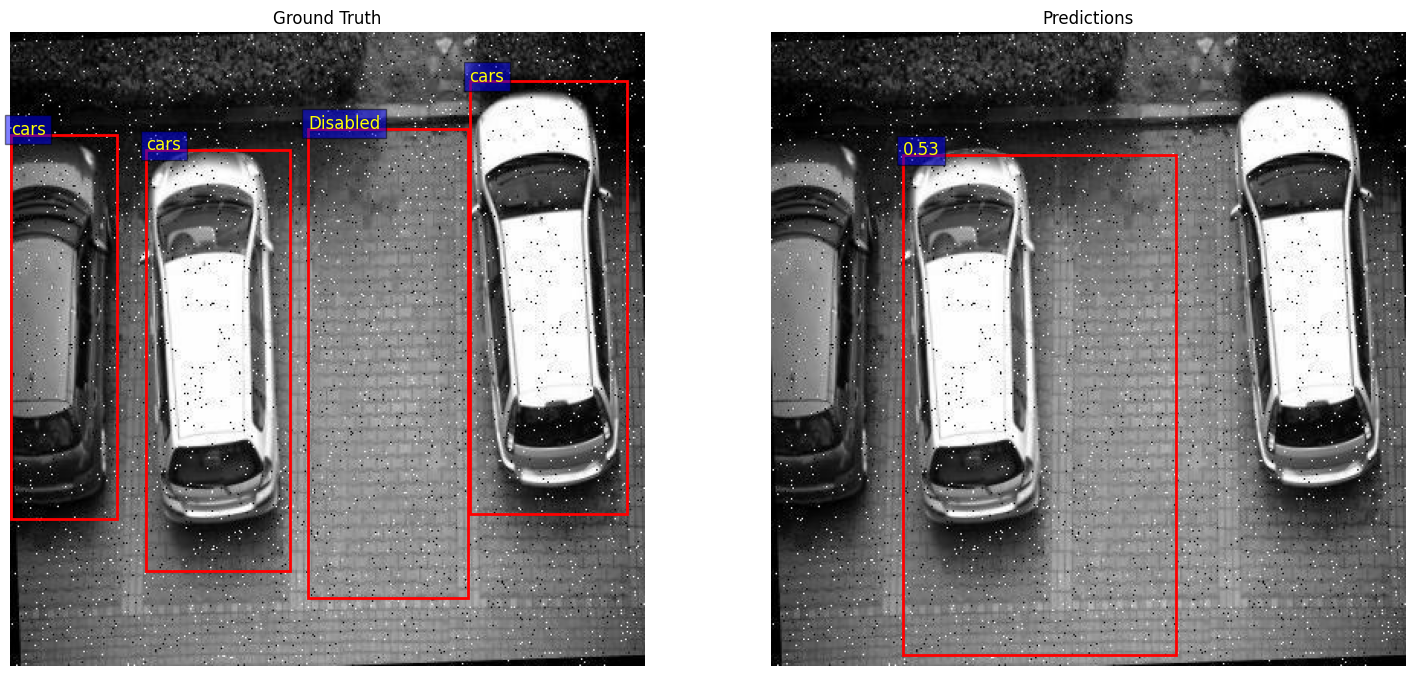

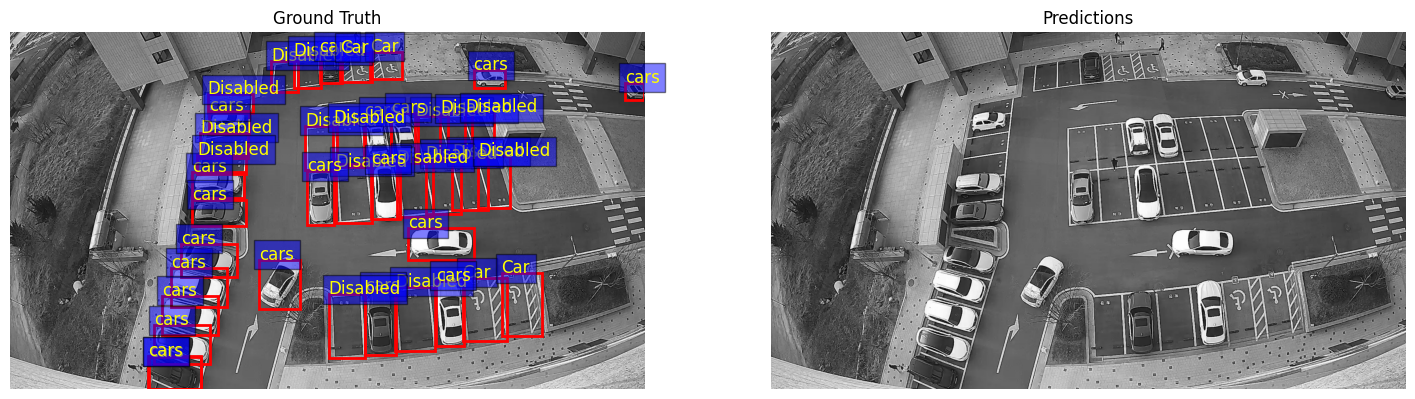

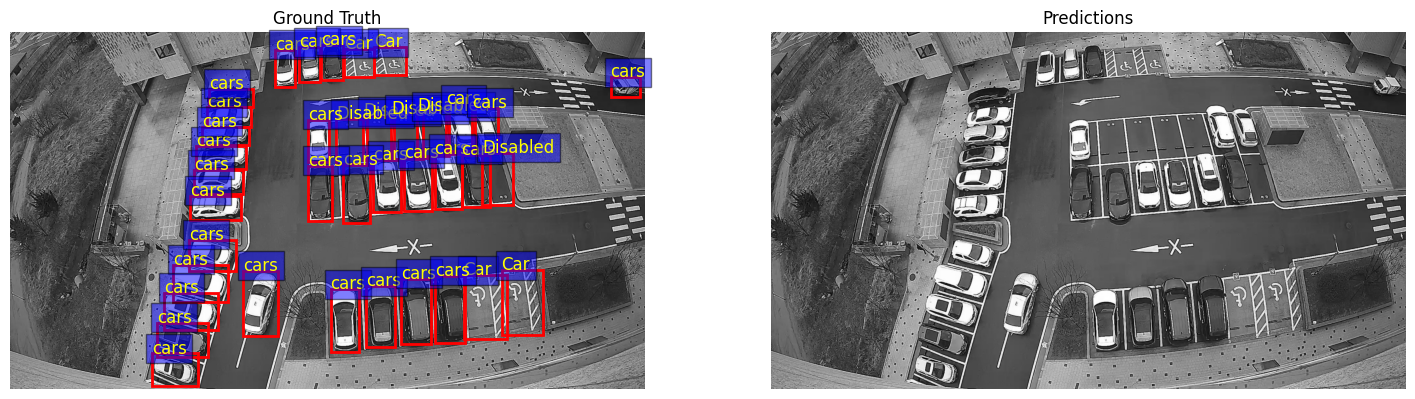

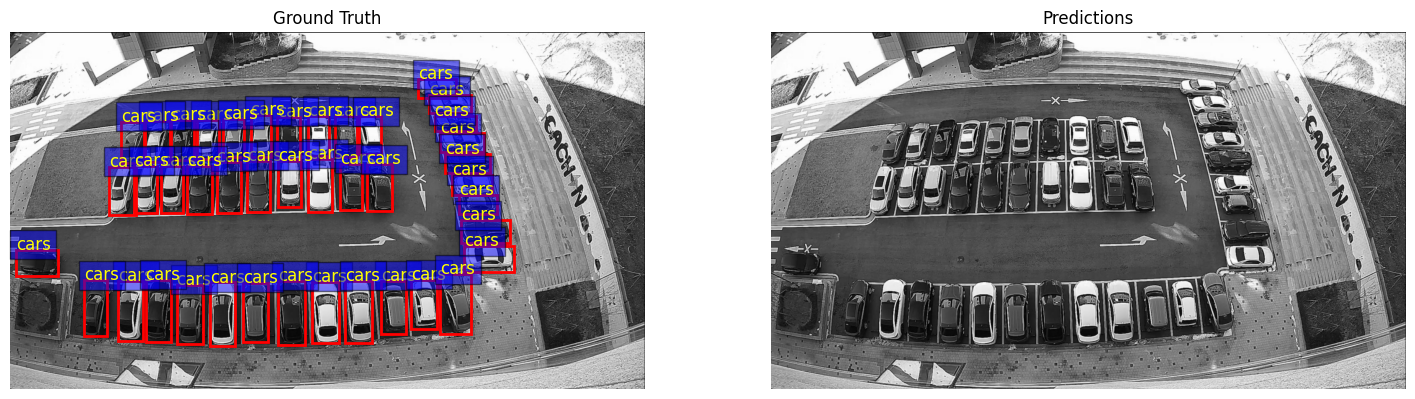

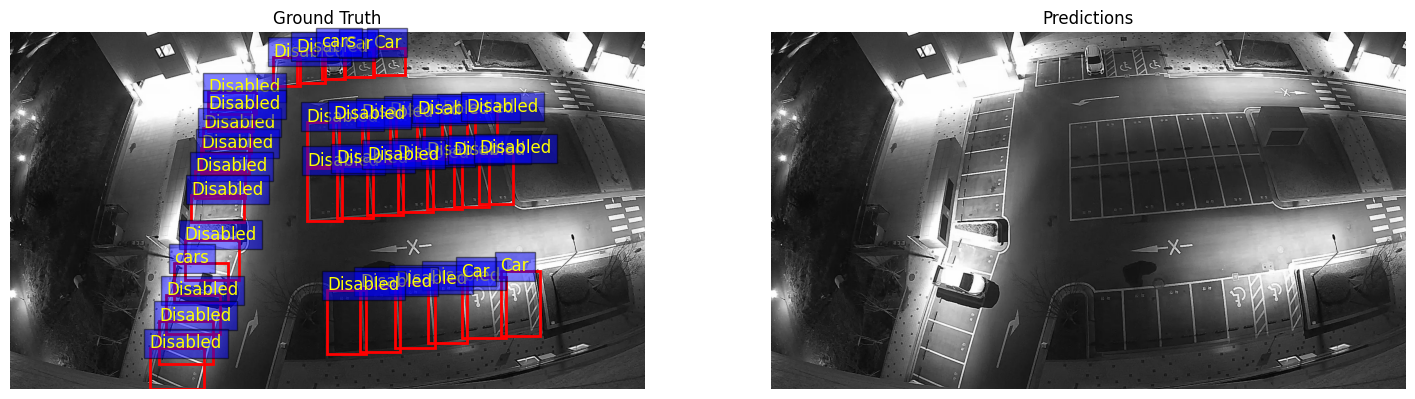

In [ ]:

# Run and visualize ground truth vs. predictions for a few test images
for image_info in coco_data['images'][:5]:  # Adjust the range to visualize more/less images
    image_id = image_info['id']
    image_path = os.path.join(image_folder, image_info['file_name'])
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to('cuda')

    # Get ground truth boxes and labels
    ground_truths = get_annotations(image_id)
    gt_boxes = [ann['bbox'] for ann in ground_truths]
    gt_labels = [coco_data['categories'][ann['category_id'] - 1]['name'] for ann in ground_truths]

    # Run model inference for predictions
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get predicted boxes and scores
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()

    # Set up the side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Plot ground truth
    visualize_boxes(ax1, image, gt_boxes, labels=gt_labels, title="Ground Truth")

    # Plot predictions with a confidence threshold
    threshold = 0.5
    filtered_pred_boxes = [box for i, box in enumerate(pred_boxes) if pred_scores[i] >= threshold]
    filtered_pred_scores = [score for score in pred_scores if score >= threshold]
    visualize_boxes(ax2, image, filtered_pred_boxes, scores=filtered_pred_scores, title="Predictions")

    plt.show()


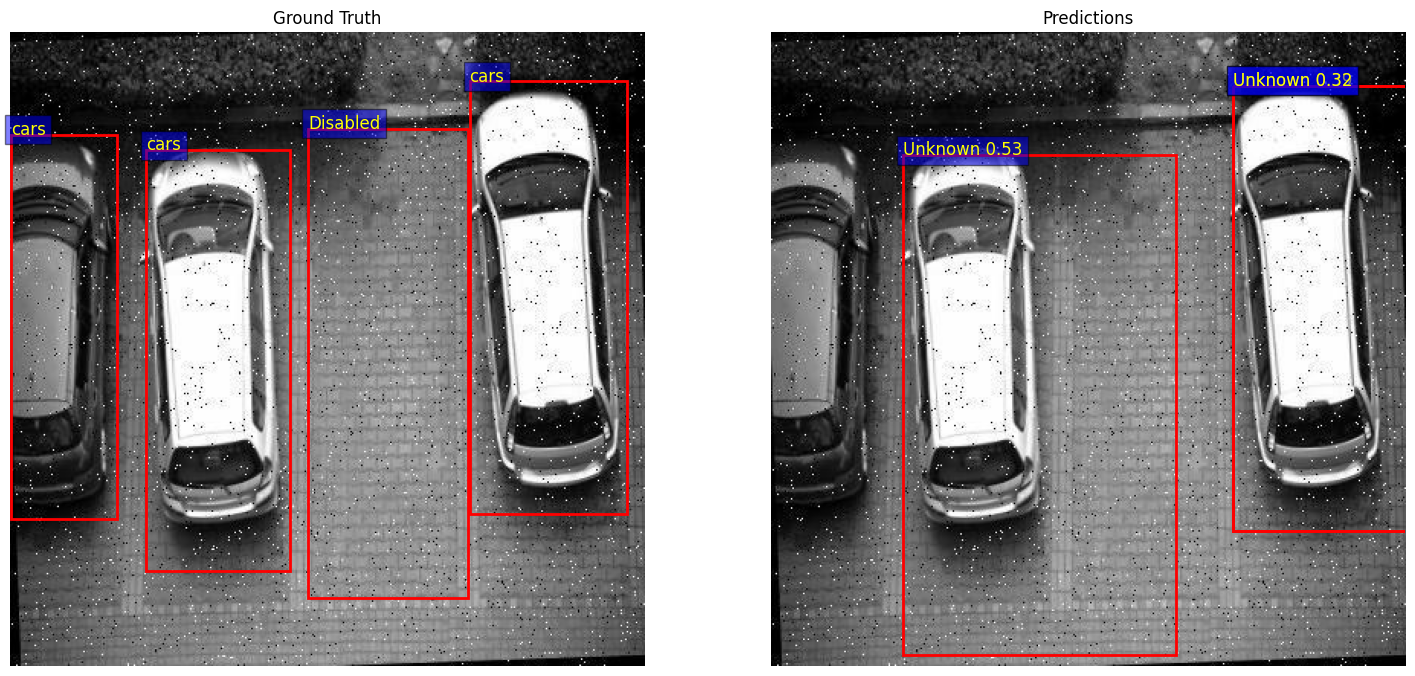

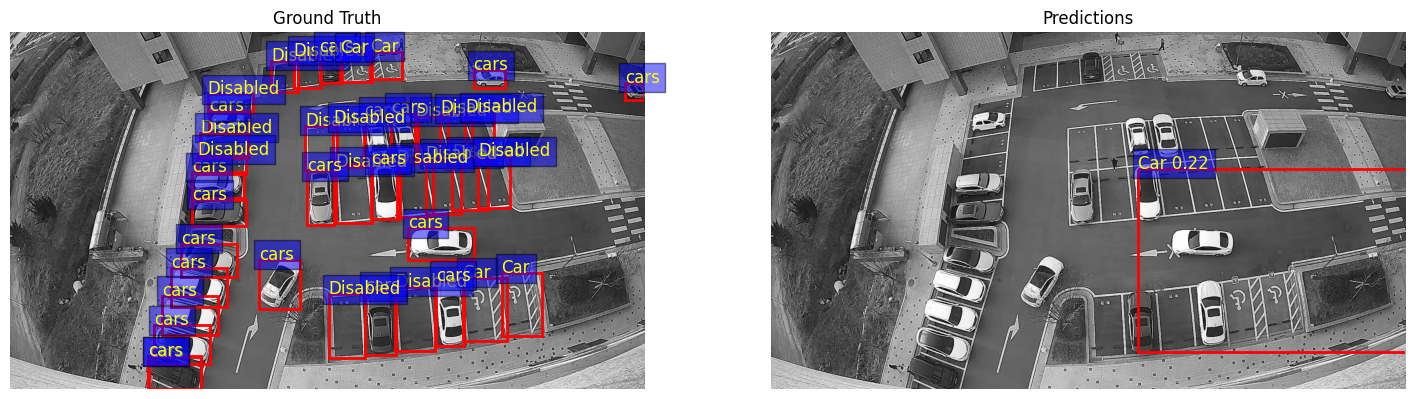

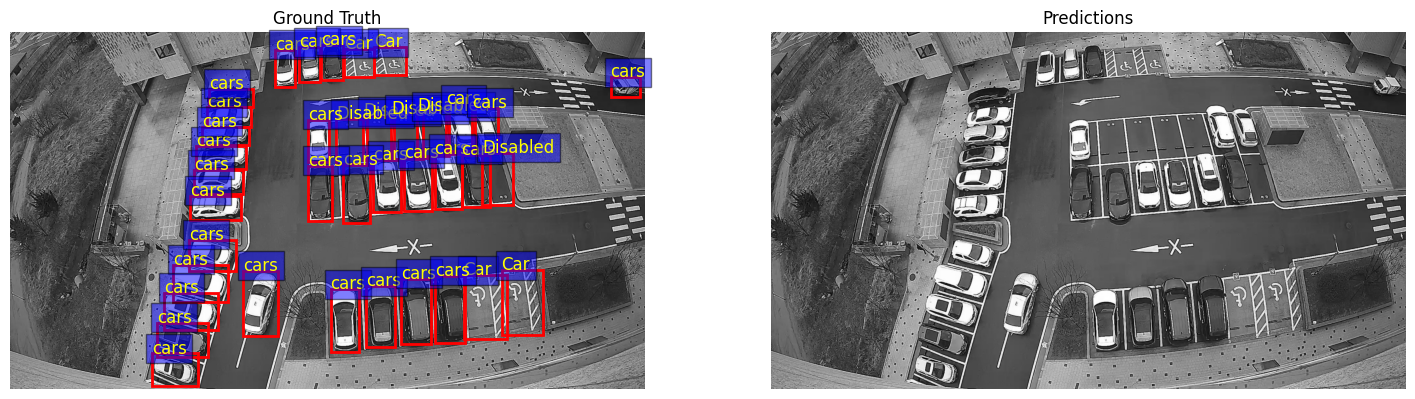

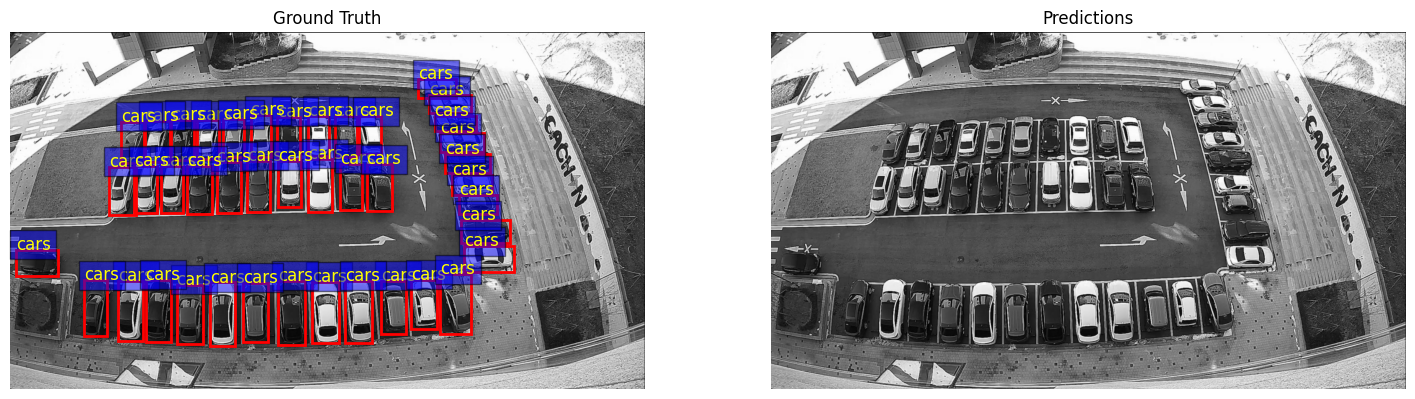

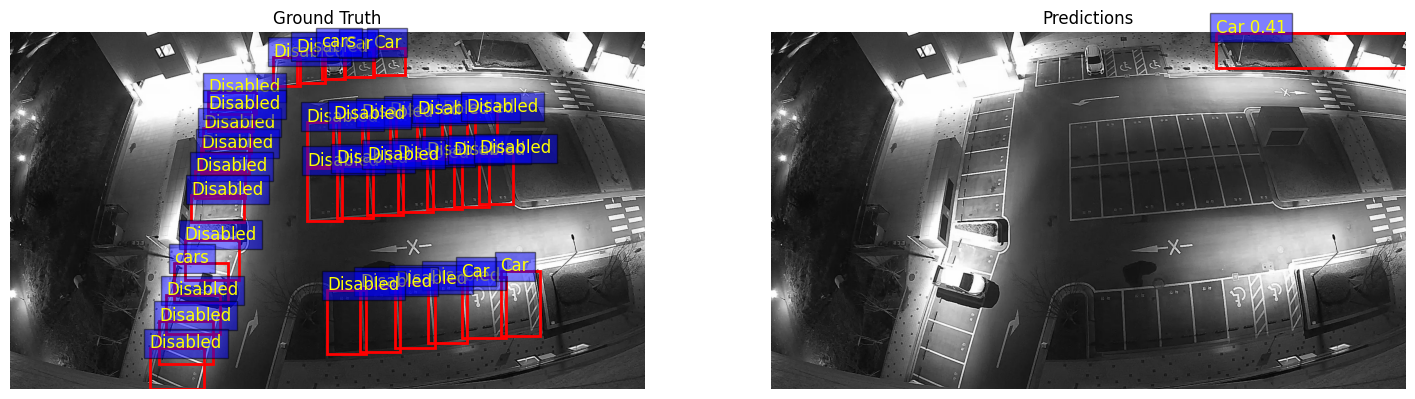

In [ ]:
# Helper function to visualize bounding boxes with labels on an image
def visualize_boxes(ax, image, boxes, scores=None, labels=None, title=""):
    ax.imshow(image)
    for i, box in enumerate(boxes):
        x_min, y_min, width, height = box[:4]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Display confidence scores or category names
        if scores is not None and labels is not None:
            label = labels[i]
            ax.text(x_min, y_min, f'{label} {scores[i]:.2f}', color='yellow', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
        elif scores is not None:
            ax.text(x_min, y_min, f'{scores[i]:.2f}', color='yellow', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
        elif labels is not None:
            ax.text(x_min, y_min, labels[i], color='yellow', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))

    ax.axis('off')
    ax.set_title(title)

# Run and visualize ground truth vs. predictions for a few test images
for image_info in coco_data['images'][:5]:  # Adjust the range to visualize more/less images
    image_id = image_info['id']
    image_path = os.path.join(image_folder, image_info['file_name'])
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to('cuda')

    # Get ground truth boxes and labels
    ground_truths = get_annotations(image_id)
    gt_boxes = [ann['bbox'] for ann in ground_truths]
    gt_labels = [coco_data['categories'][ann['category_id'] - 1]['name'] for ann in ground_truths]

    # Run model inference for predictions
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get predicted boxes, scores, and labels
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels_ids = predictions[0]['labels'].cpu().numpy()  # Assuming model returns labels

    # Map predicted labels IDs to class names (ensure label_id exists)
    category_names = {cat['id']: cat['name'] for cat in coco_data['categories']}
    pred_labels = [category_names.get(label_id, "Unknown") for label_id in pred_labels_ids]

    # Set up the side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Plot ground truth
    visualize_boxes(ax1, image, gt_boxes, labels=gt_labels, title="Ground Truth")

    # Plot predictions with a confidence threshold
    threshold = 0.2
    filtered_pred_boxes = [box for i, box in enumerate(pred_boxes) if pred_scores[i] >= threshold]
    filtered_pred_scores = [score for score in pred_scores if score >= threshold]
    filtered_pred_labels = [pred_labels[i] for i, score in enumerate(pred_scores) if score >= threshold]

    visualize_boxes(ax2, image, filtered_pred_boxes, scores=filtered_pred_scores, labels=filtered_pred_labels, title="Predictions")

    plt.show()
